In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
from desmin_reconstruction.plotting import line_and_bandplot
from desmin_reconstruction.plotting.renderings import render_pointcloud
from desmin_reconstruction.preprocessing.bbox import BoundingSquare
from desmin_reconstruction.voronoi import random_uniform_like, VoronoiAnalysis
from tqdm import tqdm


plt.rc("font", size=12)
plt.rc("grid", linestyle="--", color="lightgray")
plt.rc("axes.spines", right=False, top=False)
pv.set_jupyter_backend("static")

COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}

## Import and visualize dSTORM raw data

In [2]:
df = pl.read_csv("../data/STORM/desmin_alphaactinin_600nm.csv")
df = df.with_columns(*[pl.col(i) / 1000 for i in ("x", "y", "z")])
df = df.with_columns(*[pl.col(i) - pl.col(i).min() for i in ("x", "y", "z")])
out = df.partition_by("probe")

In [3]:
out[0]

image-ID,cycle,z-step,frame,accum,probe,photon-count,photon-count11,photon-count12,photon-count21,photon-count22,psfx,psfy,psfz,psf-photon-count,x,y,z,stdev,amp,background11,background12,background21,background22,chisq,log-likelihood,accuracy,fiducial,valid,driftx,drifty,driftz
i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
0,0,0,0,1,0,1034.72,463.85,570.867,0.0,0.0,35.9051,-40.4808,66.3892,622.579,11.110247,6.463769,0.7074228,0,21.369,28.9982,36.3168,0.0,0.0,63.7343,-806.255,27.8438,0,1,0,0,0
0,0,0,0,1,0,1123.49,658.806,464.683,0.0,0.0,-49.4319,-5.12183,-40.9081,703.38,9.302017,12.607349,0.81472,0,23.4149,30.8988,34.4805,0.0,0.0,70.0953,-811.35,24.6946,0,1,0,0,0
0,0,0,0,1,0,1085.08,584.811,500.272,0.0,0.0,-58.7007,-51.9634,-153.656,530.117,7.218427,4.382389,0.927468,0,17.5355,31.4923,36.8678,0.0,0.0,56.3151,-807.774,26.5681,0,1,0,0,0
0,0,0,0,1,0,1061.08,493.662,567.416,0.0,0.0,129.526,-12.7513,-482.199,456.65,16.896547,13.412249,1.256011,0,15.4875,31.597,37.3373,0.0,0.0,82.7346,-821.934,27.5902,0,1,0,0,0
0,0,0,0,1,0,1320.04,604.793,715.252,0.0,0.0,-20.2707,-18.4385,-164.184,1090.09,14.654547,2.554989,0.937996,0,35.5266,28.8716,34.3301,0.0,0.0,75.4246,-814.164,19.1982,0,1,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
7999,3,0,1999,1,0,1180.68,569.443,611.232,0.0,0.0,-80.1256,-155.401,-327.481,493.143,11.425547,6.479029,1.101293,0,17.2539,33.3505,43.1386,0.0,0.0,69.8483,-829.406,24.6999,0,1,22,0,0
7999,3,0,1999,1,0,1634.59,956.329,678.258,0.0,0.0,-52.1672,-12.7995,327.825,1946.25,11.198247,4.343229,0.445987,0,73.4887,32.1379,38.1334,0.0,0.0,68.1057,-835.432,14.8168,0,1,22,0,0
7999,3,0,1999,1,0,4327.59,2003.52,2324.07,0.0,0.0,25.5955,42.4264,-121.21,5506.79,10.921247,16.745549,0.895022,0,177.292,30.649,34.3714,0.0,0.0,166.348,-905.442,4.11213,0,1,22,0,0


Text(0.5, 0.01, 'x (μm)')

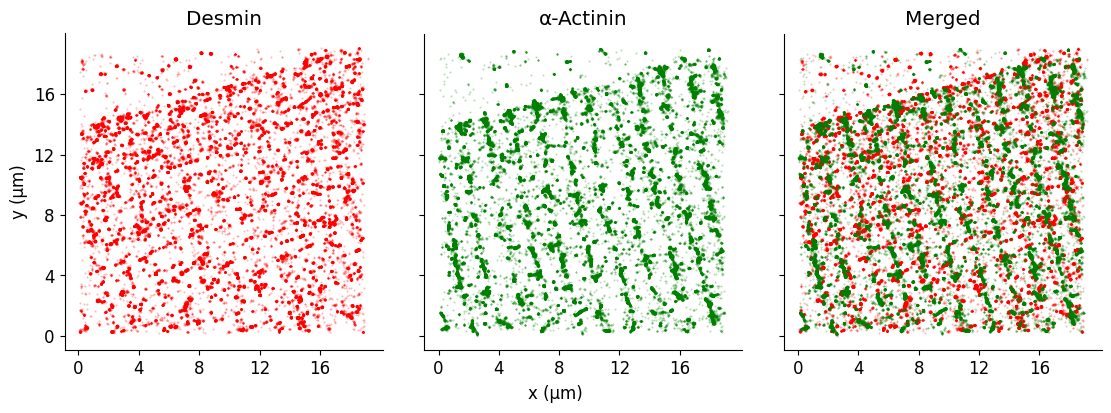

In [5]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(11, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        s=0.2,
        c="red",
        # c=np.log10(out[0]["amp"]),
        # cmap=cc.cm.kr_r,
        alpha=0.3,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        s=0.2,
        c="green",
        # c=np.log10(out[1]["amp"]),
        # cmap=cc.cm.kg_r,
        alpha=0.3,
    )

for ax, title in zip(axes, ("Desmin", "α-Actinin", "Merged")):
    ax.set_aspect("equal", "box")
    # ax.set_xlim((-0.2, 19.3))
    # ax.set_ylim((-0.2, 19.3))
    ax.set_xticks(np.arange(0, 20, 4))
    ax.set_yticks(np.arange(0, 20, 4))
    ax.set_title(title)
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

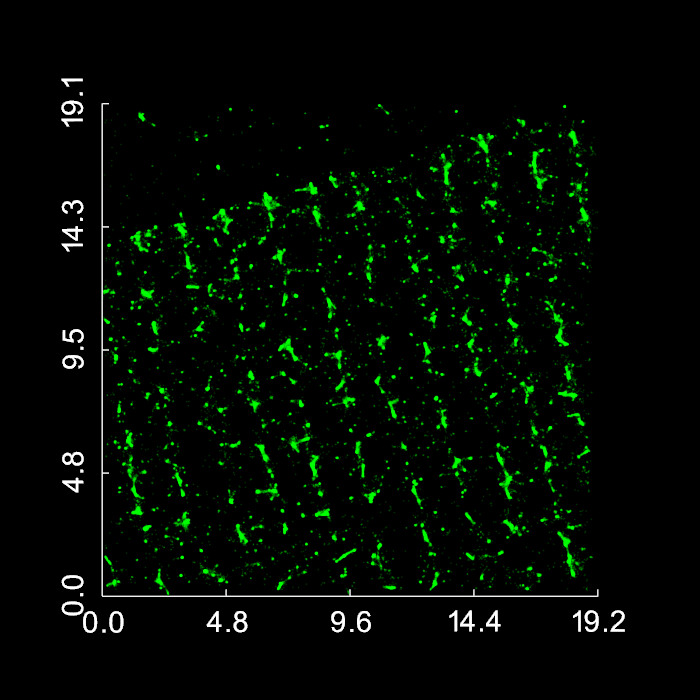

In [ ]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
p = render_pointcloud(
    p, out[0].select(["x", "y", "z"]).to_numpy(), color="#FF0000", opacity=0.0
)
p = render_pointcloud(
    p, out[1].select(["x", "y", "z"]).to_numpy(), color="#00FF00", opacity=0.2
)
p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
# p.save_graphic("../figures/supp_fig_1a/alpha-actinin.svg")

In [ ]:
voros = [VoronoiAnalysis(o.select(["x", "y", "z"]).to_numpy()) for o in out]
voro_vols = [v.region_volumes for v in voros]

100%|██████████| 154160/154160 [00:41<00:00, 3705.29it/s]


In [ ]:
def determine_threshold(localizations, n_trials: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    volumes = []
    for _ in tqdm(range(n_trials)):
        voro_rand = VoronoiAnalysis(random_uniform_like(localizations, rng))
        volumes.append(voro_rand.region_volumes)
    return volumes


voro_vol_rands = [determine_threshold(v.points) for v in voros]

100%|██████████| 10/10 [08:50<00:00, 53.05s/it]


In [12]:
voro_vol_rands_ = [np.stack(v, axis=0) for v in voro_vol_rands]
for v in voro_vol_rands_:
    print(v.shape)

(10, 77586)
(10, 154160)


In [13]:
savepath = "./data/results/desmin_alphaactinin_600nm_voronoi_volumes.npz"
np.savez(
    savepath,
    desmin=voro_vols[0],
    alpha_actinin=voro_vols[1],
    desmin_random=voro_vol_rands_[0],
    alpha_actinin_random=voro_vol_rands_[1],
)

In [16]:
voronoi_volumes = np.load(
    "../data/results/desmin_alphaactinin_600nm_voronoi_volumes.npz"
)

In [17]:
def histogram_fixed_binsize(values, bin_size, min_value=0.0, max_value=np.inf):
    values_valid = values[~np.isnan(values)]
    values_valid = np.clip(values_valid, min_value, max_value)
    bins = np.arange(min_value, max_value, bin_size)
    return np.histogram(values_valid, bins, density=True)


def internal_division_point(x1, x2, y1, y2):
    return (y1 * x2 + y2 * x1) / (y1 + y2)


def find_crossing_points(x, y1, y2):
    y_diff = y1 - y2
    x_exact_crossing = x[np.flatnonzero(y_diff == 0)]

    ind_sign_change = np.flatnonzero(y_diff[:-1] * y_diff[1:] <= 0)
    print(ind_sign_change)
    x_interped_crossing = internal_division_point(
        x[ind_sign_change],
        x[ind_sign_change + 1],
        y_diff[ind_sign_change],
        -y_diff[ind_sign_change + 1],
    )
    x_crossing = np.concatenate((x_exact_crossing, x_interped_crossing), axis=0)
    return np.sort(x_crossing)

[7.11864663e-03 4.69884335e-01 2.15364605e+00 ... 1.06808900e-02
 1.06784985e-02 2.51503514e-11]
[   5   73   74 ... 3997 3998 3999]
[0.00000000e+00 3.01480362e-02 2.78855333e-01 ... 2.26113208e-02
 2.26099500e-02 7.76524821e-13]
[  11  140  141 ... 3982 3986 3988]


/tmp/ipykernel_2629266/2330920824.py:9: RuntimeWarning: invalid value encountered in divide
  return (y1 * x2 + y2 * x1) / (y1 + y2)


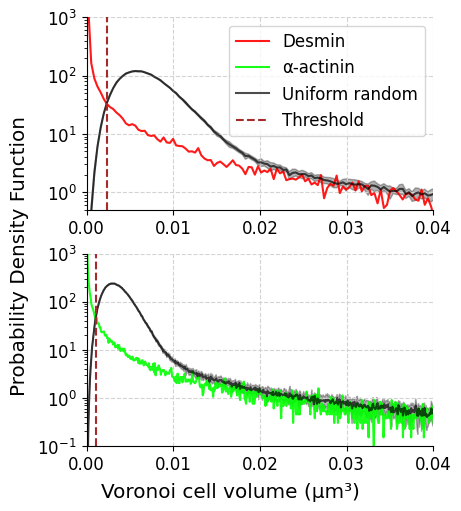

In [ ]:
vol_thresholds = []

fig, axes = plt.subplots(
    2,
    1,
    figsize=(4.5, 5),
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
names = ("desmin", "alpha_actinin")
color_dict = {"desmin": "#FF0000", "alpha_actinin": "#00FF00"}
title_dict = {"desmin": "Desmin", "alpha_actinin": "α-actinin"}
for ax, n in zip(axes, names):
    volumes_all = np.concatenate(
        [voronoi_volumes[k].flatten() for k in (n, f"{n}_random")], axis=0
    )
    volumes_all = volumes_all[np.isfinite(volumes_all)]
    bin_edges = np.histogram_bin_edges(
        volumes_all[volumes_all <= np.percentile(volumes_all, 97.5)], bins=4000
    )
    bin_edges = np.concatenate((bin_edges, np.max(volumes_all, keepdims=True)), axis=0)
    counts = np.histogram(voronoi_volumes[n], bin_edges, density=True)[0]
    counts_rand = np.stack(
        [
            np.histogram(vol, bin_edges, density=True)[0]
            for vol in voronoi_volumes[f"{n}_random"]
        ],
        axis=0,
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, counts, alpha=0.9, color=color_dict[n], label=title_dict[n])
    counts_rand_mean = np.mean(counts_rand, axis=0)
    ax = line_and_bandplot(
        ax,
        bin_centers,
        counts_rand_mean,
        np.std(counts_rand, axis=0),
        color="black",
        alpha=0.7,
        label="Uniform random",
    )
    ax.set_yscale("log")

    print(counts_rand_mean)
    vol_thres = find_crossing_points(bin_centers, counts, counts_rand_mean)[0]
    vol_thresholds.append(vol_thres)
    ax.axvline(x=vol_thres, linestyle="--", color="brown", label="Threshold")
    ax.grid(ls="--", color="lightgray")

l0, h0 = axes[0].get_legend_handles_labels()
l1, h1 = axes[1].get_legend_handles_labels()
# fig.legend([l0[0], *l1], [h0[0], *h1], loc="outside center right")
axes[0].legend([l0[0], *l1], [h0[0], *h1], loc="upper right")

axes[0].set_xlim((0, 0.04))
axes[-1].set_xlim((0, 0.04))
axes[0].set_ylim((5e-1, 1e3))
axes[1].set_ylim((1e-1, 1e3))
fig.supxlabel("Voronoi cell volume (μm³)", fontsize="large")
fig.supylabel("Probability Density Function", fontsize="large")
fig.savefig("../figures/supp_fig_1c.svg", dpi=500)

In [43]:
vol_thresholds

[np.float64(0.0023195670927630067), np.float64(0.0010387951338479459)]

In [19]:
df_filtered = [
    pl.concat(
        (
            out[i],
            pl.DataFrame({"voronoi_volume": voronoi_volumes[n]}),
        ),
        how="horizontal",
    ).filter(pl.col("voronoi_volume") <= vol_thresholds[i])
    for i, n in enumerate(("desmin", "alpha_actinin"))
]
df_filtered_total = pl.concat(df_filtered)

In [ ]:
# df_filtered_total.write_csv("../data/results/desmin_alphaactinin_600nm_filtered.csv")

## Load denoised data and inspect results

In [7]:
df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_filtered.csv")
points = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df.partition_by("probe"))
}


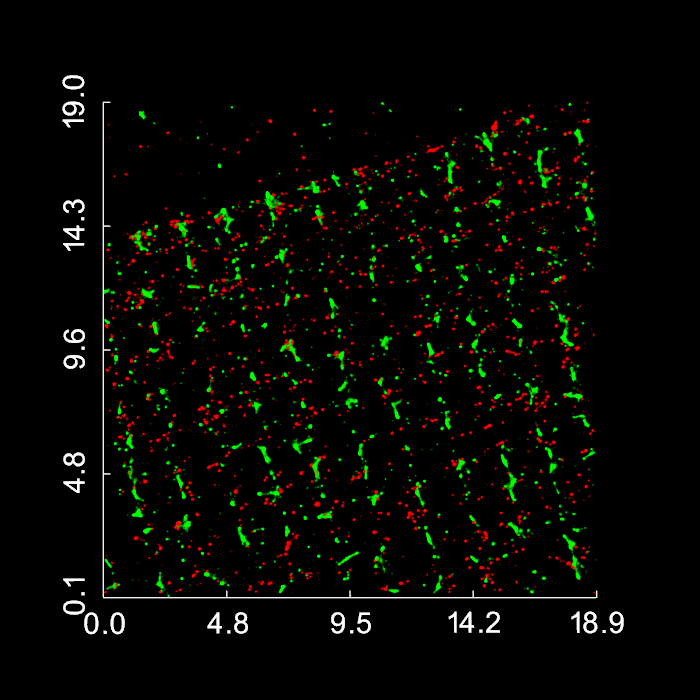

In [9]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
for name, coords in points.items():
    p = render_pointcloud(p, coords, color=COLOR_DICT[name], opacity=0.2)

p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
# p.save_graphic("../figures/supp_fig_1b/desmin.svg")

## Align ROI

In [10]:
import warnings

from desmin_reconstruction.preprocessing.storm import align_patch


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-15, 0, 0.1),
        min_cluster_size=200,
        min_samples=1,
    )

100%|██████████| 150/150 [05:55<00:00,  2.37s/it]


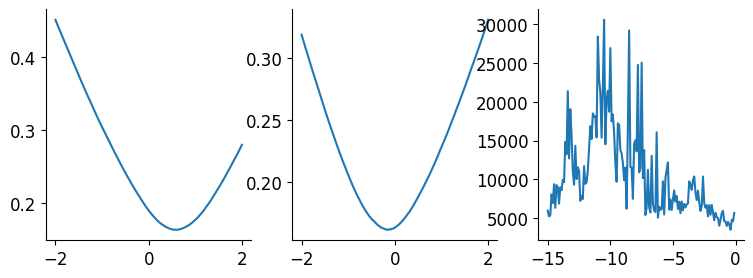

In [11]:
fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

In [27]:
coords_new = transform_fn(df.select(["x", "y", "z"]).to_numpy())
df_aligned = df.with_columns(pl.from_numpy(coords_new, schema=["x", "y", "z"]))

In [28]:
points_final = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df_aligned.partition_by("probe"))
}

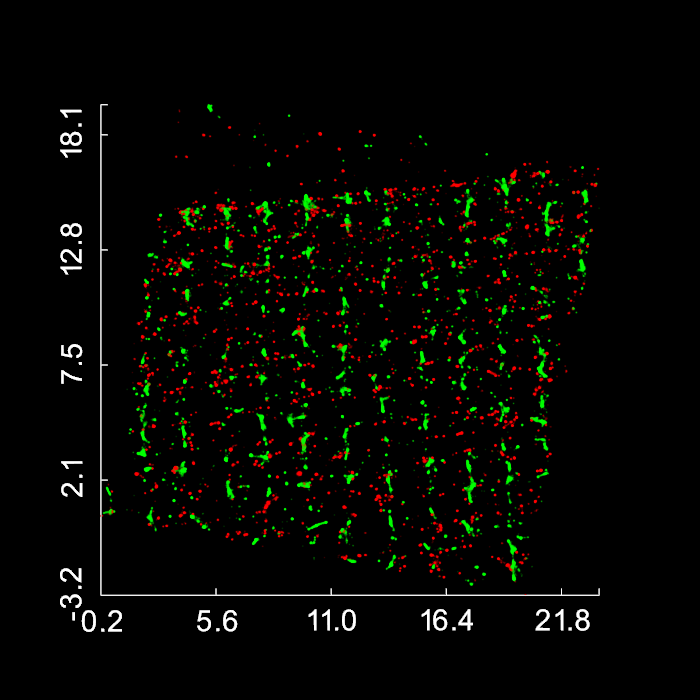

In [29]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
for name, coords in points_final.items():
    p = render_pointcloud(p, coords, color=COLOR_DICT[name], opacity=0.2)

p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
# p.save_graphic("../figures/supp_fig_1b/desmin.svg")

In [ ]:
# df_aligned.write_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")

## Choose 4um x 4um regions of interest

In [2]:
df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")
points = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df.partition_by("probe"))
}

In [5]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/pyvista/core/utilities/points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


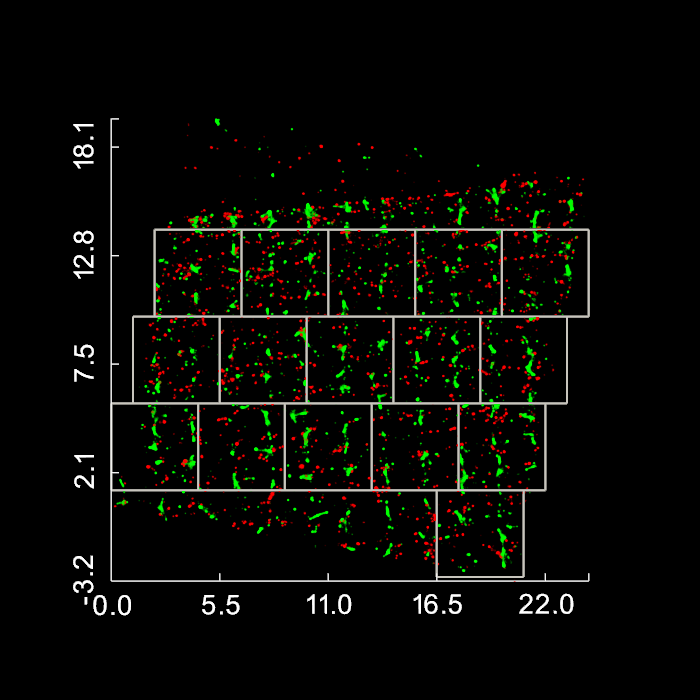

In [ ]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
for name, coords in points.items():
    p = render_pointcloud(p, coords, color=COLOR_DICT[name], opacity=0.2)

for bbox in bboxes:
    rect = pv.Rectangle(
        [[bbox.x0, bbox.y0, 10], [bbox.x1, bbox.y1, 10], [bbox.x0, bbox.y1, 10]]
    )

    p.add_mesh(
        rect,
        show_edges=True,
        style="wireframe",
        color="white",
        edge_color="white",
        line_width=2.0,
        opacity=1.0,
    )

p.enable_parallel_projection()
p.view_xy()

p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)


p.show()
p.save_graphic("../figures/supp_fig_2/2a.svg")